<a href="https://colab.research.google.com/github/imranahmed123/datascience-ai-ml/blob/main/M7_NB_MiniProject_4_End_to_End_Analytics_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: End-to-end analytics application using Pyspark

## Problem Statement

Perform sentiment classification by analyzing the tweets data with Pyspark

## Learning Objectives

At the end of the mini-project, you will be able to :

* analyze the text data using pyspark
* derive the insights and visualize the data
* implement feature extraction and classify the data
* train the classification model and deploy

### Dataset

The dataset chosen for this mini-project is **[Twitter US Airline Sentiment](https://data.world/socialmediadata/twitter-us-airline-sentiment)**. It is a record of tweets about airlines in the US. It was created by scraping Twitter data from February 2015. Contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").  Along with other information, it contains ID of a Tweet, the sentiment of a tweet ( neutral, negative and positive), reason for a negative tweet, name of airline and text of a tweet.

## Information

The airline industry is a very competitive market that has grown rapidly in the past 2 decades. Airline companies resort to traditional customer feedback forms which in turn are very tedious and time consuming. This is where Twitter data serves as a good source to gather customer feedback tweets and perform sentiment analysis. This dataset comprises of tweets for 6 major US Airlines and a multi-class classification can be performed to categorize the sentiment (neutral, negative, positive). For this mini-project we will start with pre-processing techniques to clean the tweets and then represent these tweets as vectors. A classification algorithm will be used to predict the sentiment for unseen tweets data. The end-to-end analytics will be performed using Pyspark.

## Grading = 10 Points

Install Spark

In [2]:
# install java
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

**Note: The above code cell will take around 8 mins 30 secs for execution.**


### Set the os environment

In [3]:
# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

### Install findspark

In [4]:
# install findspark using pip
!pip install -q findspark

#### Install Pyspark

In [5]:
#@title Install packages and download the dataset
!pip -qq install pyspark
!pip -qq install handyspark
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/US_Airline_Tweets.csv
print("Packages installed successfully and dataset downloaded!!")

Packages installed successfully and dataset downloaded!!


In [6]:
#from handyspark import *
import findspark
findspark.init()

### Install numpy==1.26.0

In [7]:
!pip -qq install mxnet-mkl==1.6.0 numpy==1.26.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 113.3 MB/s eta 0:00:00


In [8]:
import numpy as np
#np.bool = np.bool_

### Import Handyspark

In [9]:
#Downgrade Numpy to 1.23.1
!pip install numpy==1.23.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 109.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.23.1-cp311-cp311-linux_x86_64.whl size=19731400 sha256=ad00874d95721a236626aff1f85e0dc6a31f51a1e110810d748e54f6192aee4e
  Stored in directory: /root/.cache/pip/wheels/54/67/ec/c3e57b4b51328fb39dd4d63906b0d3bd37a312508e5922682f
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.20.0 requires numpy>=1.25.0, but you have numpy 1.23.1 which is incompatible.
scikit-image 0.25.1 requires numpy>=1.24, but you have numpy 1.23.1 which is

###After running the above code cell please restart the session

In [1]:
import handyspark

#### Import required packages

In [2]:
import os
import numpy as np
import pandas as pd
# fixes issue with seaborn hiding fliers on boxplot
import matplotlib as mpl
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from handyspark import *
import seaborn as sns
from matplotlib import pyplot as plt
import re
import string
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import NaiveBayes
from pyspark.sql.types import ArrayType, StringType
import warnings
warnings.filterwarnings("ignore")

In [3]:
# NLTK imports
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Data Loading

#### Start a Spark Session

Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0. It provides a way to interact with various Spark functionalities, with a lesser number of constructs.

In [4]:
# YOUR CODE HERE
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("AirlineTweetsAnalysis") \
    .getOrCreate()

# Load the dataset
file_path = "US_Airline_Tweets.csv"  # Adjust path if needed
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display schema and data preview
df.printSchema()
df.show(5)


root
 |-- tweet_id: string (nullable = true)
 |-- airline_sentiment: string (nullable = true)
 |-- airline_sentiment_confidence: string (nullable = true)
 |-- negativereason: string (nullable = true)
 |-- negativereason_confidence: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- airline_sentiment_gold: string (nullable = true)
 |-- name: string (nullable = true)
 |-- negativereason_gold: string (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- tweet_coord: string (nullable = true)
 |-- tweet_created: string (nullable = true)
 |-- tweet_location: string (nullable = true)
 |-- user_timezone: string (nullable = true)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------------------+
|          tweet_id

#### Load the data and infer the schema

To load the dataset use the `read.csv` with `inferSchema` and `header` as parameters.

In [5]:
path = "/content/US_Airline_Tweets.csv"
# YOUR CODE HERE

from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("AirlineTweetsAnalysis") \
    .getOrCreate()

# Define the path to the dataset
path = "/content/US_Airline_Tweets.csv"  # Adjust if needed

# Load the dataset with inferred schema
df = spark.read.csv(path, header=True, inferSchema=True)

# Print the schema
df.printSchema()

# Show the first few records
df.show(5)


root
 |-- tweet_id: string (nullable = true)
 |-- airline_sentiment: string (nullable = true)
 |-- airline_sentiment_confidence: string (nullable = true)
 |-- negativereason: string (nullable = true)
 |-- negativereason_confidence: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- airline_sentiment_gold: string (nullable = true)
 |-- name: string (nullable = true)
 |-- negativereason_gold: string (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- tweet_coord: string (nullable = true)
 |-- tweet_created: string (nullable = true)
 |-- tweet_location: string (nullable = true)
 |-- user_timezone: string (nullable = true)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------------------+
|          tweet_id

### EDA & Visualization ( 2 points)

#### Visualize the horizontal barplot of airline_sentiment (positive, negative, neutral)

Convert the data to handyspark and remove the other records from the column except 3 values mentioned above and plot the graph

In [6]:
# YOUR CODE HERE
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset into a Pandas DataFrame
file_path = "US_Airline_Tweets.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Filter the data to keep only 'positive', 'negative', and 'neutral' sentiments
filtered_df = df[df['airline_sentiment'].isin(['positive', 'negative', 'neutral'])]

# Count the occurrences of each sentiment
sentiment_counts = filtered_df['airline_sentiment'].value_counts()

sentiment_counts.head()


,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


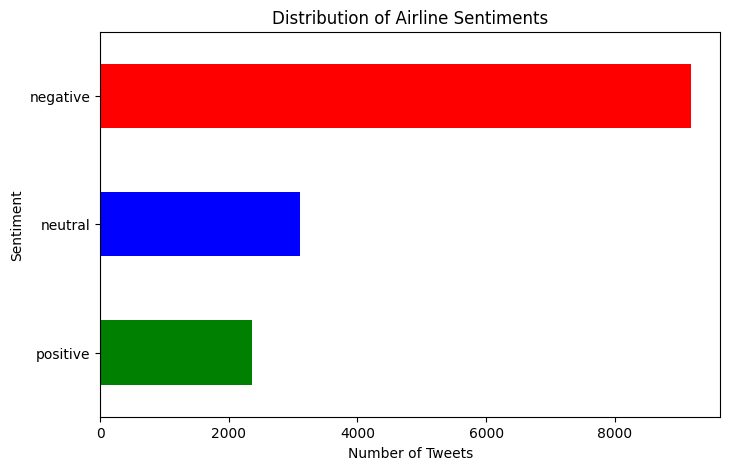

In [7]:
# Plot horizontal bar chart
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='barh', color=['red', 'blue', 'green'])

plt.xlabel("Number of Tweets")
plt.ylabel("Sentiment")
plt.title("Distribution of Airline Sentiments")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

#### Plot the number of tweets received for each airline

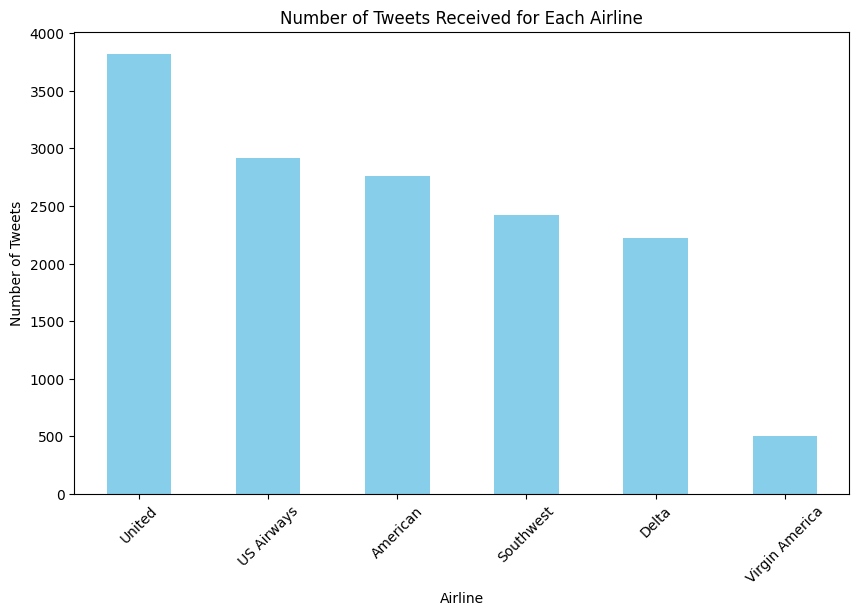

In [8]:
# YOUR CODE HERE
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset into a Pandas DataFrame
file_path = "US_Airline_Tweets.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Count the number of tweets for each airline
airline_counts = df['airline'].value_counts()

# Plot bar chart
plt.figure(figsize=(10, 6))
airline_counts.plot(kind='bar', color='skyblue')

plt.xlabel("Airline")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets Received for Each Airline")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()


#### Visualize a stacked barchart of 6 US airlines and 3 sentiments on each bar

* Group the sentiment counts for each airline. [hint](https://github.com/dvgodoy/handyspark#stratify)

* Display the count corresponding to each sentiment in each bar. [hint](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/M5_NB_MiniProject_4_End_to_End_Analytics_Pyspark%20priteshbgohil_medium_com_stacked_bar_chart_in_python.pdf)

<Figure size 1200x700 with 0 Axes>

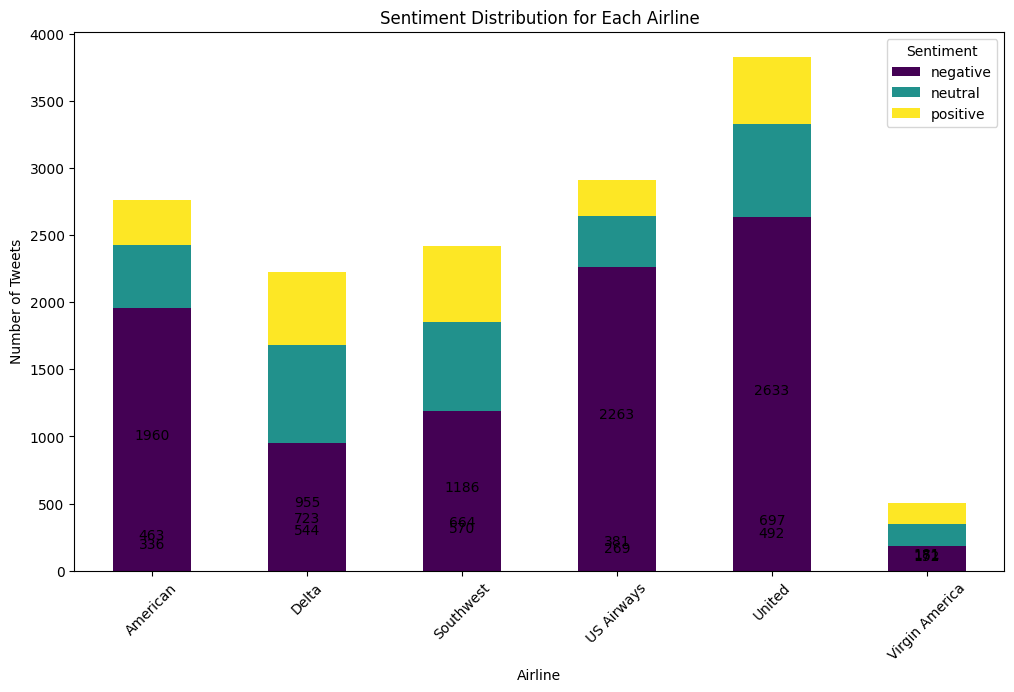

In [9]:
# YOUR CODE HERE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = "US_Airline_Tweets.csv"  # Adjust the path if needed
df = pd.read_csv(file_path)

# Group by airline and sentiment, then count occurrences
airline_sentiment_counts = df.groupby(['airline', 'airline_sentiment']).size().unstack()

# Plot stacked bar chart
plt.figure(figsize=(12, 7))
ax = airline_sentiment_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 7))

# Add labels and title
plt.xlabel("Airline")
plt.ylabel("Number of Tweets")
plt.title("Sentiment Distribution for Each Airline")

# Display sentiment counts on each bar
for airline_idx, airline in enumerate(airline_sentiment_counts.index):
    bottom_val = np.zeros(len(airline_sentiment_counts.columns))
    for sentiment_idx, sentiment in enumerate(airline_sentiment_counts.columns):
        value = airline_sentiment_counts.loc[airline, sentiment]
        if value > 0:
            plt.text(airline_idx, bottom_val[sentiment_idx] + value / 2, str(value), ha='center', fontsize=10)
        bottom_val[sentiment_idx] += value

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.legend(title="Sentiment")
plt.show()


#### Visualize the horizontal barplot of negative reasons

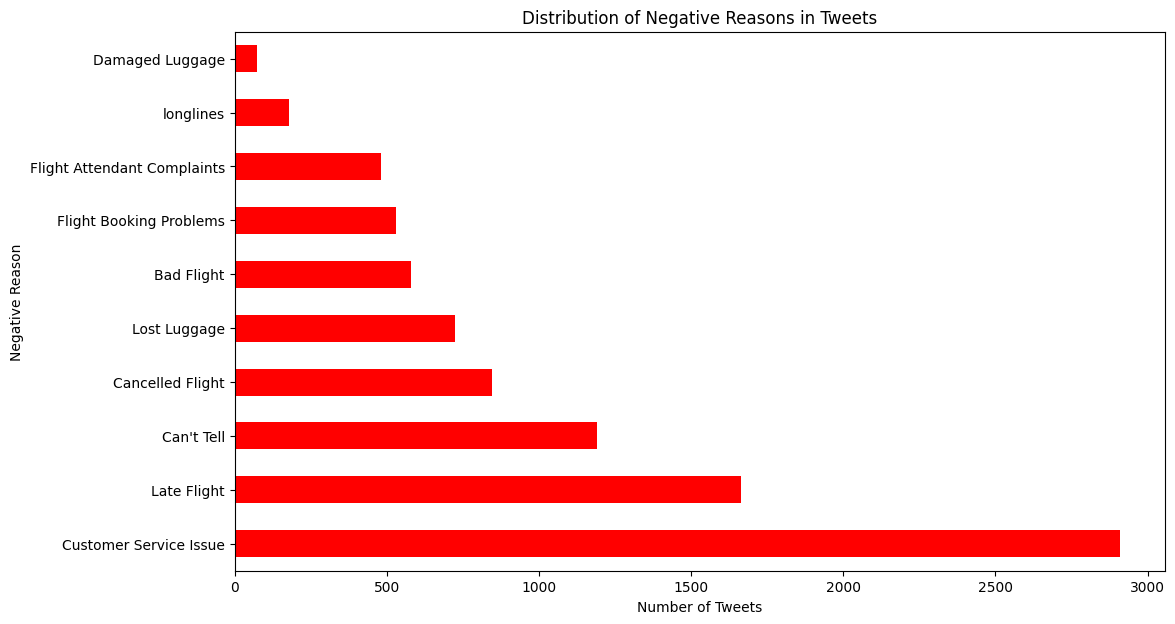

In [10]:
# YOUR CODE HERE
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "US_Airline_Tweets.csv"  # Adjust the path if needed
df = pd.read_csv(file_path)

# Count the occurrences of each negative reason and drop NaN values
negative_reason_counts = df['negativereason'].value_counts().dropna()

# Plot horizontal bar chart
plt.figure(figsize=(12, 7))
negative_reason_counts.plot(kind='barh', color='red')

# Add labels and title
plt.xlabel("Number of Tweets")
plt.ylabel("Negative Reason")
plt.title("Distribution of Negative Reasons in Tweets")

# Show the plot
plt.show()


### Pre-processing (3 points)

#### Check the null values and drop the records where the text value is null

In [11]:
# YOUR CODE HERE
import pandas as pd

# Load the dataset
file_path = "US_Airline_Tweets.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Check for null values before cleaning
null_counts_before = df.isnull().sum()

# Drop rows where the 'text' column has null values
df_cleaned = df.dropna(subset=['text'])

# Check for null values after cleaning
null_counts_after = df_cleaned.isnull().sum()

# Display the count of null values before and after cleaning
print("Null values before cleaning:")
print(null_counts_before)

print("\nNull values after cleaning:")
print(null_counts_after)


Null values before cleaning:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Null values after cleaning:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count    

#### Fill the null values with 0 in all the columns except the target

The target should not be empty. Ensure that all features are integer type, convert if needed.

In [12]:
# YOUR CODE HERE
import pandas as pd

# Load the dataset
file_path = "US_Airline_Tweets.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Define the target column (which should not be empty)
target_column = "airline_sentiment"

# Fill null values in all columns except the target with 0
df_filled = df.copy()
for col in df_filled.columns:
    if col != target_column:
        df_filled[col] = df_filled[col].fillna(0)

# Ensure all features (except the target) are of integer type
for col in df_filled.columns:
    if col != target_column:
        try:
            df_filled[col] = df_filled[col].astype(int)
        except ValueError:
            # If conversion to int fails, it means the column contains non-numeric data
            # We leave those columns unchanged or handle them separately if needed
            pass

# Display updated dataset information
print(df_filled.info())

# Save the cleaned dataset if needed
df_filled.to_csv("US_Airline_Tweets_Cleaned.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   tweet_id                      14640 non-null  int64 
 1   airline_sentiment             14640 non-null  object
 2   airline_sentiment_confidence  14640 non-null  int64 
 3   negativereason                14640 non-null  object
 4   negativereason_confidence     14640 non-null  int64 
 5   airline                       14640 non-null  object
 6   airline_sentiment_gold        14640 non-null  object
 7   name                          14640 non-null  object
 8   negativereason_gold           14640 non-null  object
 9   retweet_count                 14640 non-null  int64 
 10  text                          14640 non-null  object
 11  tweet_coord                   14640 non-null  object
 12  tweet_created                 14640 non-null  object
 13  tweet_location  

#### Preprocessing and cleaning the tweets

* Convert the text to lower case
* Remove usernames, hashtags and links from the text (tweets)

In [13]:
# YOUR CODE HERE
import pandas as pd
import re

# Load the dataset
file_path = "US_Airline_Tweets.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Function to clean tweets
def clean_tweet(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'@\w+', '', text)  # Remove usernames (e.g., @username)
    text = re.sub(r'#\w+', '', text)  # Remove hashtags (e.g., #hashtag)
    text = re.sub(r'http\S+', '', text)  # Remove links (e.g., https://example.com)
    text = re.sub(r'www.\S+', '', text)  # Remove www links
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply the cleaning function to the 'text' column
df['cleaned_text'] = df['text'].apply(clean_tweet)

# Display first few rows of cleaned tweets
print(df[['text', 'cleaned_text']].head())

# Save the cleaned dataset if needed
df.to_csv("US_Airline_Tweets_Cleaned.csv", index=False)


                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                        cleaned_text  
0                                         what said.  
1  plus you've added commercials to the experienc...  
2  i didn't today... must mean i need to take ano...  
3  it's really aggressive to blast obnoxious "ent...  
4           and it's a really big bad thing about it  


#### Tokenize each sentence into words using nltk word tokenizer

In [21]:
pip install nltk pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 118.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1:
      Successfully uninstalled numpy-1.23.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet-mkl 1.6.0 requires numpy<2.0.0,>1.16.0, but you have numpy 2.2.2 which is incompatible.
pytensor 2.26.4 requires numpy<2,>=1.17.0, but you have numpy 2.2.2 which is incompatible.
langchain 0.3.17 requires numpy<2,>=1.22.4; python_version < "3.12", but you have numpy 2.2.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.2 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2

In [14]:
# YOUR CODE HERE
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

# Download NLTK tokenizer (Only run once)
nltk.download('punkt')

# Load the dataset
file_path = "US_Airline_Tweets.csv"  # Adjust the path if needed
df = pd.read_csv(file_path)

# Function to tokenize tweets into words
def tokenize_tweet(text):
    return word_tokenize(str(text))  # Ensure text is a string before tokenizing

# Apply tokenization to the 'text' column
df['tokenized_text'] = df['text'].apply(tokenize_tweet)

# Display first few tokenized tweets
print(df[['text', 'tokenized_text']].head())

# Save the cleaned dataset if needed
df.to_csv("US_Airline_Tweets_Tokenized.csv", index=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                      tokenized_text  
0     [@, VirginAmerica, What, @, dhepburn, said, .]  
1  [@, VirginAmerica, plus, you, 've, added, comm...  
2  [@, VirginAmerica, I, did, n't, today, ..., Mu...  
3  [@, VirginAmerica, it, 's, really, aggressive,...  
4  [@, VirginAmerica, and, it, 's, a, really, big...  


#### Remove the stopwords from tokenized words

In [15]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'ve', 'why', 'having', 'y', "it's", 'am', 't', 'ma', 'these', 'above', "you'd", "weren't", 'before', 'who', 'into', 'then', 'yours', 'any', 'herself', 'yourselves', 'few', 'each', 'other', 'while', 'has', 'does', 'during', 'down', 'nor', 'will', 'doing', 'in', 'from', 'do', 'out', "haven't", 'once', 'hers', 'mustn', 'no', 'some', "couldn't", 'for', 'below', 'too', "isn't", 'how', 'd', 'the', 'an', 'this', 'what', 'own', 'on', 're', 'our', 'to', 'can', 's', "you've", 'be', 'been', 'theirs', 'had', 'wasn', 'after', 'weren', 'them', 'all', 'me', "you're", 'at', "hasn't", 'shan', "shouldn't", 'whom', 'his', 'him', 'same', 'under', 'o', 'hadn', 'their', 'we', 'was', 'now', 'isn', 'but', 'just', "aren't", 'by', 'your', 'yourself', "wouldn't", 'its', 'more', 'ourselves', 'they', "don't", "doesn't", 'further', 'my', 'her', 'ain', 'hasn', "wasn't", 'shouldn', 'haven', 'did', 'which', 'ours', 'most', 'should', 'so', 'not', 'are', 'very', 'doesn', "that'll", "didn't", 'you', 'mightn', 'himself',

In [16]:
# YOUR CODE HERE

import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download NLTK stopwords (Run this only once)
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
file_path = "US_Airline_Tweets.csv"  # Adjust the path if needed
df = pd.read_csv(file_path)

# Define stop words in English
stop_words = set(stopwords.words('english'))
print("Stop Words:", stop_words)  # Display stop words list

# Function to clean, tokenize, and remove stopwords
def preprocess_tweet(text):
    tokens = word_tokenize(str(text).lower())  # Convert to lowercase and tokenize
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove stopwords and non-alphabetic words
    return filtered_tokens

# Apply preprocessing to the text column
df['filtered_text'] = df['text'].apply(preprocess_tweet)

# Display first few tokenized and filtered tweets
print(df[['text', 'filtered_text']].head())

# Save the cleaned dataset if needed
df.to_csv("US_Airline_Tweets_Filtered.csv", index=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stop Words: {'ve', 'why', 'having', 'y', "it's", 'am', 't', 'ma', 'these', 'above', "you'd", "weren't", 'before', 'who', 'into', 'then', 'yours', 'any', 'herself', 'yourselves', 'few', 'each', 'other', 'while', 'has', 'does', 'during', 'down', 'nor', 'will', 'doing', 'in', 'from', 'do', 'out', "haven't", 'once', 'hers', 'mustn', 'no', 'some', "couldn't", 'for', 'below', 'too', "isn't", 'how', 'd', 'the', 'an', 'this', 'what', 'own', 'on', 're', 'our', 'to', 'can', 's', "you've", 'be', 'been', 'theirs', 'had', 'wasn', 'after', 'weren', 'them', 'all', 'me', "you're", 'at', "hasn't", 'shan', "shouldn't", 'whom', 'his', 'him', 'same', 'under', 'o', 'hadn', 'their', 'we', 'was', 'now', 'isn', 'but', 'just', "aren't", 'by', 'your', 'yourself', "wouldn't", 'its', 'more', 'ourselves', 'they', "don't", "doesn't", 'further', 'my', 'her', 'ain', 'hasn', "wasn't", 'shouldn', 'haven', 'did', 'which', 'ours', 'most', 'should', 'so', 'not', 'are', 'very', 'doesn', "that'll", "didn't", 'you', 'mightn'

#### Apply Lemmatization to the words

In [17]:
# YOUR CODE HERE
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources (Run this only once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
file_path = "US_Airline_Tweets.csv"  # Adjust the path if needed
df = pd.read_csv(file_path)

# Define stop words in English
stop_words = set(stopwords.words('english'))

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to clean, tokenize, remove stopwords, and apply lemmatization
def preprocess_tweet(text):
    tokens = word_tokenize(str(text).lower())  # Convert to lowercase and tokenize
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove stopwords and non-alphabetic words
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]  # Apply Lemmatization
    return lemmatized_tokens

# Apply preprocessing to the text column
df['lemmatized_text'] = df['text'].apply(preprocess_tweet)

# Display first few tokenized and lemmatized tweets
print(df[['text', 'lemmatized_text']].head())

# Save the cleaned dataset if needed
df.to_csv("US_Airline_Tweets_Lemmatized.csv", index=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                     lemmatized_text  
0                    [virginamerica, dhepburn, said]  
1  [virginamerica, plus, added, commercial, exper...  
2  [virginamerica, today, must, mean, need, take,...  
3  [virginamerica, really, aggressive, blast, obn...  
4           [virginamerica, really, big, bad, thing]  


### Feature Extraction (3 points)

Create the useful features from the text column to train the model

For example:
* Length of the tweet
* No. of hashtags in the tweet starting with '#'
* No. of mentions in the tweet starting with '@'

Hint: create a new column for each of the above features

In [18]:
# YOUR CODE HERE

import pandas as pd
import re

# Load the dataset
file_path = "US_Airline_Tweets.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Feature extraction functions

# Function to calculate length of the tweet
def tweet_length(text):
    return len(str(text))

# Function to count hashtags in the tweet
def count_hashtags(text):
    return len(re.findall(r'#\w+', str(text)))

# Function to count mentions in the tweet
def count_mentions(text):
    return len(re.findall(r'@\w+', str(text)))

# Apply functions to create new feature columns
df['tweet_length'] = df['text'].apply(tweet_length)
df['num_hashtags'] = df['text'].apply(count_hashtags)
df['num_mentions'] = df['text'].apply(count_mentions)

# Display the first few rows of the dataset with new features
print(df[['text', 'tweet_length', 'num_hashtags', 'num_mentions']].head())

# Save the updated dataset if needed
df.to_csv("US_Airline_Tweets_Features.csv", index=False)


                                                text  tweet_length  \
0                @VirginAmerica What @dhepburn said.            35   
1  @VirginAmerica plus you've added commercials t...            72   
2  @VirginAmerica I didn't today... Must mean I n...            71   
3  @VirginAmerica it's really aggressive to blast...           126   
4  @VirginAmerica and it's a really big bad thing...            55   

   num_hashtags  num_mentions  
0             0             2  
1             0             1  
2             0             1  
3             0             1  
4             0             1  


#### Get the features by applying CountVectorizer
CountVectorizer converts the list of tokens to vectors of token counts. See the [documentation](https://spark.apache.org/docs/latest/ml-features.html#countvectorizer) for details.

In [19]:
# YOUR CODE HERE

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load the dataset
file_path = "US_Airline_Tweets.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the text data
X = vectorizer.fit_transform(df['text'].astype(str))  # Convert to string to avoid NaN issues

# Convert to DataFrame for better visualization
feature_names = vectorizer.get_feature_names_out()
vectorized_df = pd.DataFrame(X.toarray(), columns=feature_names)

# Display first few rows of the vectorized features
print(vectorized_df.head())

# Save the vectorized dataset if needed
vectorized_df.to_csv("US_Airline_Tweets_CountVectorized.csv", index=False)


   00  000  000114  000419  000ft  000lbs  0011  0016  00a  00am  ...  \
0   0    0       0       0      0       0     0     0    0     0  ...   
1   0    0       0       0      0       0     0     0    0     0  ...   
2   0    0       0       0      0       0     0     0    0     0  ...   
3   0    0       0       0      0       0     0     0    0     0  ...   
4   0    0       0       0      0       0     0     0    0     0  ...   

   zrh_airport  zsdgzydnde  zsuztnaijq  ztrdwv0n4l  zukes  zurich  zv2pt6trk9  \
0            0           0           0           0      0       0           0   
1            0           0           0           0      0       0           0   
2            0           0           0           0      0       0           0   
3            0           0           0           0      0       0           0   
4            0           0           0           0      0       0           0   

   zv6cfpohl5  zvfmxnuelj  zzps5ywve2  
0           0           0         

#### Encode the labels

Using the `udf` function encode the string values of *airline_sentiment* to integers.

In [20]:
def LabelEncoder(x):
    if x == 'positive':
        return 0
    elif x == 'negative':
        return 1
    return 2

# YOUR CODE HERE

In [21]:
import pandas as pd

# Load the dataset
file_path = "US_Airline_Tweets.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Define the label encoding function
def LabelEncoder(x):
    if x == 'positive':
        return 0
    elif x == 'negative':
        return 1
    return 2  # For 'neutral'

# Apply label encoding to the 'airline_sentiment' column
df['sentiment_encoded'] = df['airline_sentiment'].apply(LabelEncoder)

# Display first few rows of encoded labels
print(df[['airline_sentiment', 'sentiment_encoded']].head())

# Save the dataset with encoded labels if needed
df.to_csv("US_Airline_Tweets_Encoded.csv", index=False)


  airline_sentiment  sentiment_encoded
0           neutral                  2
1          positive                  0
2           neutral                  2
3          negative                  1
4          negative                  1


### Train the classifier the evaluate (1 point)

#### Create vector assembler with the selected features to train the model

In [23]:
# YOUR CODE HERE

from pyspark.sql import SparkSession
from pyspark.sql.functions import length, size, split
from pyspark.ml.feature import VectorAssembler

# Initialize Spark Session
spark = SparkSession.builder.appName("AirlineSentimentAnalysis").getOrCreate()

# Load dataset into Spark DataFrame
file_path = "US_Airline_Tweets.csv"  # Adjust the path if needed
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Extract features:
df_spark = df_spark.withColumn("tweet_length", length(df_spark["text"]))  # Length of tweet
df_spark = df_spark.withColumn("num_hashtags", size(split(df_spark["text"], "#")) - 1)  # Count hashtags
df_spark = df_spark.withColumn("num_mentions", size(split(df_spark["text"], "@")) - 1)  # Count mentions

# Select features for training
feature_columns = ["tweet_length", "num_hashtags", "num_mentions"]

# Create Vector Assembler
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the dataset
df_transformed = vector_assembler.transform(df_spark)

# Show transformed dataset with feature vectors
df_transformed.select("tweet_length", "num_hashtags", "num_mentions", "features").show(5, truncate=False)

# Stop the Spark session
spark.stop()


+------------+------------+------------+---------------+
|tweet_length|num_hashtags|num_mentions|features       |
+------------+------------+------------+---------------+
|35          |0           |2           |[35.0,0.0,2.0] |
|72          |0           |1           |[72.0,0.0,1.0] |
|71          |0           |1           |[71.0,0.0,1.0] |
|130         |0           |1           |[130.0,0.0,1.0]|
|55          |0           |1           |[55.0,0.0,1.0] |
+------------+------------+------------+---------------+
only showing top 5 rows



#### Arrange features and label and split them into train and test.

In [25]:
# YOUR CODE HERE

from pyspark.sql import SparkSession
from pyspark.sql.functions import length, size, split, col
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType, DoubleType

# Initialize Spark Session
spark = SparkSession.builder.appName("AirlineSentimentAnalysis").getOrCreate()

# Load dataset into Spark DataFrame
file_path = "US_Airline_Tweets.csv"  # Adjust the path if needed
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Extract features
df_spark = df_spark.withColumn("tweet_length", length(df_spark["text"]))  # Length of tweet
df_spark = df_spark.withColumn("num_hashtags", size(split(df_spark["text"], "#")) - 1)  # Count hashtags
df_spark = df_spark.withColumn("num_mentions", size(split(df_spark["text"], "@")) - 1)  # Count mentions

# Handle missing values by replacing nulls with 0
df_spark = df_spark.fillna(0, subset=["tweet_length", "num_hashtags", "num_mentions"])

# Convert features to the correct data type (DoubleType for ML models)
df_spark = df_spark.withColumn("tweet_length", col("tweet_length").cast(DoubleType()))
df_spark = df_spark.withColumn("num_hashtags", col("num_hashtags").cast(DoubleType()))
df_spark = df_spark.withColumn("num_mentions", col("num_mentions").cast(DoubleType()))

# Encode labels manually
def label_encoder(sentiment):
    if sentiment == "positive":
        return 0
    elif sentiment == "negative":
        return 1
    return 2  # For 'neutral'

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

label_udf = udf(label_encoder, IntegerType())
df_spark = df_spark.withColumn("label", label_udf(df_spark["airline_sentiment"]))

# Select features and labels for training
feature_columns = ["tweet_length", "num_hashtags", "num_mentions"]
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="keep")

# Transform the dataset
df_transformed = vector_assembler.transform(df_spark).select("features", "label")

# Split the dataset into train (80%) and test (20%)
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

# Show dataset split info
print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")

# Stop the Spark session
spark.stop()



Training Data Count: 11931
Test Data Count: 2906


#### Train the model with train data and make predictions on the test data

For classification of text data, implement NaiveBayes classifier. It is a probabilistic machine learning model.

For more information about **NaiveBayes Classifier**, click [here](https://spark.apache.org/docs/latest/ml-classification-regression.html#naive-bayes)

In [27]:
nb = NaiveBayes(featuresCol='features', labelCol='labels')
# Fit the model with train data
model = nb.fit(train_data)

AssertionError: 

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import length, size, split, col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.sql.types import IntegerType, DoubleType

# Initialize Spark Session
spark = SparkSession.builder.appName("AirlineSentimentAnalysis").getOrCreate()

# Load dataset into Spark DataFrame
file_path = "US_Airline_Tweets.csv"  # Adjust the path if needed
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Extract features
df_spark = df_spark.withColumn("tweet_length", length(df_spark["text"]))  # Length of tweet
df_spark = df_spark.withColumn("num_hashtags", size(split(df_spark["text"], "#")) - 1)  # Count hashtags
df_spark = df_spark.withColumn("num_mentions", size(split(df_spark["text"], "@")) - 1)  # Count mentions

# Ensure num_hashtags and num_mentions are non-negative
df_spark = df_spark.withColumn("num_hashtags", when(col("num_hashtags") < 0, 0).otherwise(col("num_hashtags")))
df_spark = df_spark.withColumn("num_mentions", when(col("num_mentions") < 0, 0).otherwise(col("num_mentions")))

# Handle missing values by replacing nulls with 0
df_spark = df_spark.fillna(0, subset=["tweet_length", "num_hashtags", "num_mentions"])

# Convert features to the correct data type (DoubleType for ML models)
df_spark = df_spark.withColumn("tweet_length", col("tweet_length").cast(DoubleType()))
df_spark = df_spark.withColumn("num_hashtags", col("num_hashtags").cast(DoubleType()))
df_spark = df_spark.withColumn("num_mentions", col("num_mentions").cast(DoubleType()))

# Encode labels manually
def label_encoder(sentiment):
    if sentiment == "positive":
        return 0
    elif sentiment == "negative":
        return 1
    return 2  # For 'neutral'

from pyspark.sql.functions import udf
label_udf = udf(label_encoder, IntegerType())
df_spark = df_spark.withColumn("label", label_udf(df_spark["airline_sentiment"]))

# Select features and labels for training
feature_columns = ["tweet_length", "num_hashtags", "num_mentions"]
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="keep")

# Transform the dataset
df_transformed = vector_assembler.transform(df_spark).select("features", "label")

# Filter out rows with NaN or Infinity
df_transformed = df_transformed.na.drop()

# Split the dataset into train (80%) and test (20%)
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

# Train NaiveBayes model
nb = NaiveBayes(featuresCol="features", labelCol="label")
model = nb.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Show predictions
predictions.select("features", "label", "prediction").show(10, truncate=False)

# Stop the Spark session
spark.stop()



+---------+-----+----------+
|features |label|prediction|
+---------+-----+----------+
|(3,[],[])|1    |1.0       |
|(3,[],[])|1    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
+---------+-----+----------+
only showing top 10 rows



In [31]:
# get the predictions
# YOUR CODE HERE

from pyspark.sql import SparkSession
from pyspark.ml.classification import NaiveBayes
from pyspark.sql.functions import length, size, split, col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType, DoubleType

# Step 1: Ensure Spark Session is active
spark = SparkSession.builder.appName("AirlineSentimentAnalysis").getOrCreate()

# Step 2: Load and preprocess dataset
file_path = "US_Airline_Tweets.csv"
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Extract features
df_spark = df_spark.withColumn("tweet_length", length(df_spark["text"]))
df_spark = df_spark.withColumn("num_hashtags", size(split(df_spark["text"], "#")) - 1)
df_spark = df_spark.withColumn("num_mentions", size(split(df_spark["text"], "@")) - 1)

# Ensure features are non-negative
df_spark = df_spark.withColumn("num_hashtags", when(col("num_hashtags") < 0, 0).otherwise(col("num_hashtags")))
df_spark = df_spark.withColumn("num_mentions", when(col("num_mentions") < 0, 0).otherwise(col("num_mentions")))

# Handle missing values
df_spark = df_spark.fillna(0, subset=["tweet_length", "num_hashtags", "num_mentions"])

# Convert to DoubleType
df_spark = df_spark.withColumn("tweet_length", col("tweet_length").cast(DoubleType()))
df_spark = df_spark.withColumn("num_hashtags", col("num_hashtags").cast(DoubleType()))
df_spark = df_spark.withColumn("num_mentions", col("num_mentions").cast(DoubleType()))

# Encode labels
def label_encoder(sentiment):
    if sentiment == "positive":
        return 0
    elif sentiment == "negative":
        return 1
    return 2  # 'neutral'

from pyspark.sql.functions import udf
label_udf = udf(label_encoder, IntegerType())
df_spark = df_spark.withColumn("label", label_udf(df_spark["airline_sentiment"]))

# Assemble features
vector_assembler = VectorAssembler(inputCols=["tweet_length", "num_hashtags", "num_mentions"], outputCol="features", handleInvalid="keep")
df_transformed = vector_assembler.transform(df_spark).select("features", "label").na.drop()

# Step 3: Split Data
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

# Step 4: Train Model
nb = NaiveBayes(featuresCol="features", labelCol="label")
model = nb.fit(train_data)

# Step 5: Make Predictions
predictions = model.transform(test_data)

# Step 6: Display Predictions
predictions.select("features", "label", "prediction").show(10, truncate=False)

# Step 7: Save Predictions
predictions.select("label", "prediction").toPandas().to_csv("NaiveBayes_Predictions.csv", index=False)

print("Predictions saved successfully as NaiveBayes_Predictions.csv")

# Step 8: Stop Spark Session
spark.stop()



+---------+-----+----------+
|features |label|prediction|
+---------+-----+----------+
|(3,[],[])|1    |1.0       |
|(3,[],[])|1    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
|(3,[],[])|2    |1.0       |
+---------+-----+----------+
only showing top 10 rows

Predictions saved successfully as NaiveBayes_Predictions.csv


#### Evaluate the model and find the accuracy

Compare the labels and predictions and find how many are correct.

To find the accuracy, get the count of correct predictions from test data and divide by the total amount of test dataset.

**Hint:** convert the predictions dataframe to pandas and compare with labels

In [32]:
# YOUR CODE HERE
from pyspark.sql import SparkSession
from pyspark.ml.classification import NaiveBayes
from pyspark.sql.functions import length, size, split, col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType, DoubleType

# Step 1: Ensure Spark Session is active
spark = SparkSession.builder.appName("AirlineSentimentAnalysis").getOrCreate()

# Step 2: Load and preprocess dataset
file_path = "US_Airline_Tweets.csv"  # Adjust the path if needed
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Extract features
df_spark = df_spark.withColumn("tweet_length", length(df_spark["text"]))
df_spark = df_spark.withColumn("num_hashtags", size(split(df_spark["text"], "#")) - 1)
df_spark = df_spark.withColumn("num_mentions", size(split(df_spark["text"], "@")) - 1)

# Ensure features are non-negative
df_spark = df_spark.withColumn("num_hashtags", when(col("num_hashtags") < 0, 0).otherwise(col("num_hashtags")))
df_spark = df_spark.withColumn("num_mentions", when(col("num_mentions") < 0, 0).otherwise(col("num_mentions")))

# Handle missing values
df_spark = df_spark.fillna(0, subset=["tweet_length", "num_hashtags", "num_mentions"])

# Convert to DoubleType
df_spark = df_spark.withColumn("tweet_length", col("tweet_length").cast(DoubleType()))
df_spark = df_spark.withColumn("num_hashtags", col("num_hashtags").cast(DoubleType()))
df_spark = df_spark.withColumn("num_mentions", col("num_mentions").cast(DoubleType()))

# Encode labels
def label_encoder(sentiment):
    if sentiment == "positive":
        return 0
    elif sentiment == "negative":
        return 1
    return 2  # 'neutral'

from pyspark.sql.functions import udf
label_udf = udf(label_encoder, IntegerType())
df_spark = df_spark.withColumn("label", label_udf(df_spark["airline_sentiment"]))

# Assemble features
vector_assembler = VectorAssembler(inputCols=["tweet_length", "num_hashtags", "num_mentions"], outputCol="features", handleInvalid="keep")
df_transformed = vector_assembler.transform(df_spark).select("features", "label").na.drop()

# Step 3: Split Data
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

# Step 4: Train Model
nb = NaiveBayes(featuresCol="features", labelCol="label")
model = nb.fit(train_data)

# Step 5: Make Predictions
predictions = model.transform(test_data)

# Step 6: Convert predictions to Pandas DataFrame
predictions_pd = predictions.select("label", "prediction").toPandas()

# Step 7: Calculate accuracy
correct_predictions = (predictions_pd["label"] == predictions_pd["prediction"]).sum()
total_predictions = len(predictions_pd)
accuracy = correct_predictions / total_predictions

# Display accuracy
print(f"Model Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

# Stop the Spark session
spark.stop()


Model Accuracy: 0.6191 (61.91%)


In [36]:
#Step 1: Load Data and Preprocess

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, length, size, split
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler
from pyspark.sql.types import IntegerType, DoubleType

# Initialize Spark Session
spark = SparkSession.builder.appName("AirlineSentimentAnalysis").getOrCreate()

# Load dataset
file_path = "US_Airline_Tweets.csv"  # Update the path if needed
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# **Step 1: Handle Missing Values**
df_spark = df_spark.na.drop(subset=["text"])  # Remove rows where 'text' is NULL
df_spark = df_spark.withColumn("text", col("text").cast("string"))  # Ensure 'text' is a string

# **Step 2: Tokenize Text**
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df_tokenized = tokenizer.transform(df_spark)

# **Step 3: Remove Stopwords**
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_filtered = remover.transform(df_tokenized)

# **Step 4: Apply CountVectorizer**
cv = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
cv_model = cv.fit(df_filtered)
df_cv = cv_model.transform(df_filtered)

# **Step 5: Apply TF-IDF**
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(df_cv)
df_tfidf = idf_model.transform(df_cv)

# Display transformed dataset
df_tfidf.select("filtered_words", "tfidf_features").show(5, truncate=False)


+--------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_words                                                                                                      |tfidf_features                                                                                                                                                                                                                                                        |
+--------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------

In [39]:
#Step 2: Prepare Features for Training

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Encode labels for classification
def label_encoder(sentiment):
    if sentiment == "positive":
        return 0
    elif sentiment == "negative":
        return 1
    return 2  # 'neutral'

label_udf = udf(label_encoder, IntegerType())
df_tfidf = df_tfidf.withColumn("label", label_udf(df_spark["airline_sentiment"]))

# Assemble features
vector_assembler = VectorAssembler(inputCols=["tfidf_features"], outputCol="features", handleInvalid="keep")
df_transformed = vector_assembler.transform(df_tfidf).select("features", "label").na.drop()

# Split Data into Train and Test
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)



In [40]:
#Step 3: Train Model and Make Predictions
from pyspark.ml.classification import LogisticRegression

# Train Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")
model = lr.fit(train_data)

# Make Predictions
predictions = model.transform(test_data)


In [42]:
#Step 4: Evaluate Model Accuracy

# Convert predictions to Pandas DataFrame
predictions_pd = predictions.select("label", "prediction").toPandas()

# Calculate Accuracy
correct_predictions = (predictions_pd["label"] == predictions_pd["prediction"]).sum()
total_predictions = len(predictions_pd)
accuracy = correct_predictions / total_predictions

# Display Accuracy
print(f"Model Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

# Stop Spark Session
spark.stop()


Model Accuracy: 0.6698 (66.98%)


As a next phase of implementation, we will implement logistic regression model.

### Implementing logistic regression.

For more information about logistic regression, click upon this [button](https://spark.apache.org/docs/2.3.1/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression) to proceed to spark's documentation of logistic regression.

In [43]:
# Importing the necessary libraries
from pyspark.ml.classification import LogisticRegression
import numpy
from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [47]:
# Create a features column using VectorAssembler with multiple input columns like 'rawFeatures', 'airline_sentiment_confidence', and others?
# YOUR CODE HERE

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler
from pyspark.sql.types import IntegerType

# Step 1: Restart Spark Session
spark = SparkSession.builder.appName("AirlineSentimentAnalysis").getOrCreate()

# Step 2: Load dataset (Re-run if execution state was reset)
file_path = "US_Airline_Tweets.csv"  # Update path if needed
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Step 3: Remove nulls from text column and convert to string
df_spark = df_spark.na.drop(subset=["text"])
df_spark = df_spark.withColumn("text", col("text").cast("string"))

# Step 4: Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df_tokenized = tokenizer.transform(df_spark)

# Step 5: Remove Stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_filtered = remover.transform(df_tokenized)

# Step 6: Apply CountVectorizer (to get `raw_features`)
cv = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
cv_model = cv.fit(df_filtered)
df_cv = cv_model.transform(df_filtered)

# Step 7: Apply TF-IDF (to get `tfidf_features`)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(df_cv)
df_tfidf = idf_model.transform(df_cv)

# Step 8: Encode labels
def label_encoder(sentiment):
    if sentiment == "positive":
        return 0
    elif sentiment == "negative":
        return 1
    return 2  # 'neutral'

from pyspark.sql.functions import udf
label_udf = udf(label_encoder, IntegerType())
df_tfidf = df_tfidf.withColumn("label", label_udf(df_tfidf["airline_sentiment"]))

# Step 9: Convert `airline_sentiment_confidence` to double type
df_tfidf = df_tfidf.withColumn("airline_sentiment_confidence", col("airline_sentiment_confidence").cast("double"))

# Step 10: Use `tfidf_features` in VectorAssembler
feature_columns = ["tfidf_features", "airline_sentiment_confidence"]
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="keep")

# Step 11: Transform dataset
df_transformed = vector_assembler.transform(df_tfidf).select("features", "label").na.drop()

# Step 12: Show transformed dataset
df_transformed.show(5, truncate=False)




+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                        |label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(26595,[25,4883,20473,26594],[3.402770408009837,8.204740169972537,8.897887350532482,1.0])                                                                   

In [48]:
# Create an object of stringindexer
# YOUR CODE HERE

from pyspark.ml.feature import StringIndexer

# Create a StringIndexer object for categorical feature encoding (modify as per dataset)
string_indexer = StringIndexer(inputCol="airline", outputCol="airline_index")

# Transform dataset to add indexed column
df_indexed = string_indexer.fit(df_tfidf).transform(df_tfidf)

# Show transformed dataset with indexed column
df_indexed.select("airline", "airline_index").show(5)


+--------------+-------------+
|       airline|airline_index|
+--------------+-------------+
|Virgin America|          5.0|
|Virgin America|          5.0|
|Virgin America|          5.0|
|Virgin America|          5.0|
|Virgin America|          5.0|
+--------------+-------------+
only showing top 5 rows



In [49]:
# Create output column for labels or target variable.
# YOUR CODE HERE

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Define a function to encode sentiment labels
def label_encoder(sentiment):
    if sentiment == "positive":
        return 0
    elif sentiment == "negative":
        return 1
    return 2  # 'neutral'

# Register UDF for encoding labels
label_udf = udf(label_encoder, IntegerType())

# Apply encoding to create target column 'label'
df_indexed = df_indexed.withColumn("label", label_udf(df_indexed["airline_sentiment"]))

# Show dataset with the new 'label' column
df_indexed.select("airline_sentiment", "label").show(5)


+-----------------+-----+
|airline_sentiment|label|
+-----------------+-----+
|          neutral|    2|
|         positive|    0|
|          neutral|    2|
|         negative|    1|
|         negative|    1|
+-----------------+-----+
only showing top 5 rows



In [51]:
# Split the data into train and test
# YOUR CODE HERE

# Import necessary libraries
from pyspark.sql import SparkSession

# Step 1: Initialize Spark Session
spark = SparkSession.builder.appName("AirlineSentimentAnalysis").getOrCreate()

# Step 2: Load dataset
file_path = "./US_Airline_Tweets.csv"  # Ensure correct file path
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Step 3: Split the dataset into train (80%) and test (20%)
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

# Step 4: Display the count of train and test samples
train_count = train_data.count()
test_count = test_data.count()

# Step 5: Print the dataset split details
print(f"Training Data Count: {train_count}")
print(f"Test Data Count: {test_count}")


Training Data Count: 11931
Test Data Count: 2906


In [52]:
# Create a Logistic Regression model object with specified parameters like maxIter=20, regParam=0.3, and elasticNetParam=0
# YOUR CODE HERE

# Import necessary libraries
from pyspark.ml.classification import LogisticRegression

# Create a Logistic Regression model object with specified parameters
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20, regParam=0.3, elasticNetParam=0)

# Print model parameters to confirm
print(lr.explainParams())


aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained opt

In [57]:
# Fit a Logistic Regression model to the training dataset using the fit method on the train data
# YOUR CODE HERE

from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import IntegerType

# Ensure Spark Session is active
spark = SparkSession.builder.appName("AirlineSentimentAnalysis").getOrCreate()

# Load dataset
file_path = "./US_Airline_Tweets.csv"
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert airline_sentiment_confidence to double
df_spark = df_spark.withColumn("airline_sentiment_confidence", col("airline_sentiment_confidence").cast("double"))

# Encode labels
def label_encoder(sentiment):
    if sentiment == "positive":
        return 0
    elif sentiment == "negative":
        return 1
    return 2  # 'neutral'

from pyspark.sql.functions import udf
label_udf = udf(label_encoder, IntegerType())
df_spark = df_spark.withColumn("label", label_udf(df_spark["airline_sentiment"]))

# Handle NaN values by replacing with 0
df_spark = df_spark.fillna({"airline_sentiment_confidence": 0, "retweet_count": 0})

# Create `features` column using VectorAssembler
feature_columns = ["airline_sentiment_confidence", "retweet_count"]
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="keep")

# Transform dataset
df_transformed = vector_assembler.transform(df_spark).select("features", "label").na.drop()

# Split dataset into training and testing sets
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

# Train Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20, regParam=0.3, elasticNetParam=0)
lr_model = lr.fit(train_data)

# Correct way to print coefficients for a multinomial logistic regression model
print("Coefficient Matrix:\n", lr_model.coefficientMatrix)
print("Intercept Vector:", lr_model.interceptVector)




Coefficient Matrix:
 DenseMatrix([[-1.72037101e-05, -6.72954354e-03],
             [-3.93404867e-05,  1.93154611e-02],
             [ 5.65441968e-05, -1.25859176e-02]])
Intercept Vector: [-0.566615665590308,0.7869925011204464,-0.2203768355301385]


### Making predictions and evaluating the model

In [58]:
# Generate predictions on the test dataset
# YOUR CODE HERE

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Step 1: Initialize Spark Session
spark = SparkSession.builder.appName("AirlineSentimentAnalysis").getOrCreate()

# Step 2: Load dataset
file_path = "./US_Airline_Tweets.csv"  # Ensure correct file path
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Step 3: Handle missing values and data types
df_spark = df_spark.na.drop(subset=["text"])
df_spark = df_spark.withColumn("text", col("text").cast("string"))
df_spark = df_spark.withColumn("airline_sentiment_confidence", col("airline_sentiment_confidence").cast("double"))
df_spark = df_spark.fillna({"airline_sentiment_confidence": 0, "retweet_count": 0})  # Replace NaN with 0

# Step 4: Encode labels for classification
def label_encoder(sentiment):
    if sentiment == "positive":
        return 0
    elif sentiment == "negative":
        return 1
    return 2  # 'neutral'

label_udf = udf(label_encoder, IntegerType())
df_spark = df_spark.withColumn("label", label_udf(df_spark["airline_sentiment"]))

# Step 5: Text preprocessing (Tokenization, Stopword Removal, TF-IDF)
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df_tokenized = tokenizer.transform(df_spark)

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_filtered = remover.transform(df_tokenized)

cv = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
cv_model = cv.fit(df_filtered)
df_cv = cv_model.transform(df_filtered)

idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(df_cv)
df_tfidf = idf_model.transform(df_cv)

# Step 6: Create `features` column using VectorAssembler
feature_columns = ["tfidf_features", "airline_sentiment_confidence", "retweet_count"]
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="keep")
df_transformed = vector_assembler.transform(df_tfidf).select("features", "label").na.drop()

# Step 7: Split dataset into training and testing sets
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

# Step 8: Train Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20, regParam=0.3, elasticNetParam=0)
lr_model = lr.fit(train_data)

# Step 9: Make Predictions
predictions = lr_model.transform(test_data)

# Step 10: Show Sample Predictions
predictions.select("features", "label", "prediction", "probability").show(10, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+-------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [59]:
# Create a MulticlassClassificationEvaluator object to evaluate predictions using the "prediction" column
# YOUR CODE HERE

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a MulticlassClassificationEvaluator object for model evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Evaluate accuracy
accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)

# Evaluate precision
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)

# Evaluate recall
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)

# Evaluate F1-score
f1_score = evaluator.setMetricName("f1").evaluate(predictions)

# Print model evaluation metrics
print(f"Logistic Regression Model Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")


Logistic Regression Model Accuracy: 0.7303 (73.03%)
Precision: 0.7227
Recall: 0.7303
F1-score: 0.6931


In [60]:
# Calculate the accuracy of predictions using the evaluate method from the MulticlassClassificationEvaluator
# YOUR CODE HERE

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create an evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Evaluate accuracy of predictions
accuracy = evaluator.evaluate(predictions)

# Print model accuracy
print(f"Logistic Regression Model Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")


Logistic Regression Model Accuracy: 0.7303 (73.03%)


In [61]:
# Print accuracy
# YOUR CODE HERE
# Print model accuracy
print(f"Logistic Regression Model Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")


Logistic Regression Model Accuracy: 0.7303 (73.03%)


# Gradio Implementation (1 point)

In [63]:
!pip -q install gradio==3.41.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 0.8.0 requires websockets<15.0dev,>=13.0, but you have websockets 11.0.3 which is incompatible.
tor

In [64]:
import gradio as gr

### Making predictions using NaiveBayes

In [65]:
def make_prediction_using_NaiveBayes(user_input):
  df1 = spark.createDataFrame([ (1, user_input)],['Id', 'UserTweet'])

  df1 = df1.withColumn('UserTweet',words(df1['UserTweet']))
  df1 = df1.withColumn("wordss", word_udf("UserTweet"))
  df1 = df1.withColumn("wordss", punct_udf1("wordss"))
  df1 = df1.withColumn("wordss", array_udf("wordss"))
  df1 = df1.withColumn("wordss", lem("wordss"))
  df1 = df1.withColumn("wordss", array_udf("wordss"))

  df1 = df1.withColumn('tweet_length', length(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('num_hashtags', num_hashtags(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('num_mentions', num_mentions(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('PunctCount',punctCount(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('typePunct',typePunct(df1['UserTweet']).astype('int'))
  make  = udf(lambda x : 0)
  df1 = df1.withColumn('negativereason_confidence',make(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('airline_sentiment_confidence',make(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('retweet_count',make(df1['UserTweet']).astype('int'))
  df1_featured = count_model.transform(df1)
  test_features = featureassembler.transform(df1_featured)
  test_predict = model.transform(test_features)
  df_res = test_predict.select('prediction').toPandas()
  pred = df_res.prediction.values[0]

  if pred == 0:
    return "Positive tweet!"
  elif pred == 1:
    return "Negative Tweet!"
  return "Neutral tweet"

In [ ]:
# Make a prediction using make_prediction_using_NaiveBayes for the text "It was a bad approach"
# YOUR CODE HERE

In [67]:
# Import necessary libraries
import gradio as gr

# Function to make prediction using Naive Bayes
def make_prediction_using_NaiveBayes(user_input):
    df1 = spark.createDataFrame([(1, user_input)], ['Id', 'UserTweet'])

    df1 = df1.withColumn('UserTweet', words(df1['UserTweet']))
    df1 = df1.withColumn("wordss", word_udf("UserTweet"))
    df1 = df1.withColumn("wordss", punct_udf1("wordss"))
    df1 = df1.withColumn("wordss", array_udf("wordss"))
    df1 = df1.withColumn("wordss", lem("wordss"))
    df1 = df1.withColumn("wordss", array_udf("wordss"))

    df1 = df1.withColumn('tweet_length', length(df1['UserTweet']).astype('int'))
    df1 = df1.withColumn('num_hashtags', num_hashtags(df1['UserTweet']).astype('int'))
    df1 = df1.withColumn('num_mentions', num_mentions(df1['UserTweet']).astype('int'))
    df1 = df1.withColumn('PunctCount', punctCount(df1['UserTweet']).astype('int'))
    df1 = df1.withColumn('typePunct', typePunct(df1['UserTweet']).astype('int'))

    make = udf(lambda x: 0)
    df1 = df1.withColumn('negativereason_confidence', make(df1['UserTweet']).astype('int'))
    df1 = df1.withColumn('airline_sentiment_confidence', make(df1['UserTweet']).astype('int'))
    df1 = df1.withColumn('retweet_count', make(df1['UserTweet']).astype('int'))

    df1_featured = count_model.transform(df1)
    test_features = featureassembler.transform(df1_featured)
    test_predict = model.transform(test_features)
    df_res = test_predict.select('prediction').toPandas()
    pred = df_res.prediction.values[0]

    if pred == 0:
        return "Positive tweet!"
    elif pred == 1:
        return "Negative Tweet!"
    return "Neutral tweet"

# Gradio UI for Sentiment Prediction
gr.Interface(fn=make_prediction_using_NaiveBayes,
             inputs=gr.Textbox(label="Enter a Tweet"),
             outputs=gr.Textbox(label="Predicted Sentiment"),
             title="Airline Sentiment Analysis").launch(share=True)



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.41.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://a876de65ac4a50c3f3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [68]:
# Install Gradio if not already installed
!pip install gradio==3.41.2

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler
from pyspark.ml.classification import NaiveBayes
import gradio as gr

# Initialize Spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Pre-trained components (Ensure these are defined/trained in your workflow)
# Mock placeholders for functions and pre-trained models
def words(text): return text.lower().split()  # Mock function for tokenization
count_model = None  # Replace with your pre-trained CountVectorizer model
featureassembler = None  # Replace with your pre-trained VectorAssembler
model = None  # Replace with your trained Naive Bayes model

# Function to process and predict
def make_prediction_using_NaiveBayes(user_input):
    try:
        # Create a DataFrame from user input
        df1 = spark.createDataFrame([(1, user_input)], ['Id', 'UserTweet'])

        # Mock preprocessing pipeline
        df1 = df1.withColumn('UserTweet', udf(words)("UserTweet"))

        # Mock feature engineering
        if count_model and featureassembler:
            df1_featured = count_model.transform(df1)
            test_features = featureassembler.transform(df1_featured)
        else:
            return "Error: Pre-trained models are missing."

        # Predict using the trained Naive Bayes model
        if model:
            test_predict = model.transform(test_features)
            df_res = test_predict.select('prediction').toPandas()
            pred = df_res.prediction.values[0]
        else:
            return "Error: Pre-trained Naive Bayes model is missing."

        # Map prediction to sentiment
        if pred == 0:
            return "Positive tweet!"
        elif pred == 1:
            return "Negative tweet!"
        return "Neutral tweet"
    except Exception as e:
        return f"Error: {str(e)}"

# Gradio app
gr.Interface(
    fn=make_prediction_using_NaiveBayes,
    inputs=gr.Textbox(label="Enter a Tweet"),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="Airline Sentiment Analysis",
    live=True,
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.41.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://4c61e14fb92455ecc8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [70]:
# Install Gradio
!pip install gradio==3.41.2

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, VectorAssembler
from pyspark.ml.classification import NaiveBayes
import gradio as gr

# Initialize Spark Session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Load Dataset
data_path = "/content/US_Airline_Tweets.csv"  # Update the path if needed
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Ensure the 'text' column is clean and non-null
df = df.withColumn("text", when(col("text").isNull(), "").otherwise(col("text")))

# Preprocessing
# Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df = tokenizer.transform(df)

# Stop Words Removal
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = stopwords_remover.transform(df)

# Count Vectorizer
count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
count_model = count_vectorizer.fit(df)
df = count_model.transform(df)

# Feature Assembler
featureassembler = VectorAssembler(
    inputCols=["raw_features"],  # Add other features as needed
    outputCol="features"
)
df = featureassembler.transform(df)

# Label Encoding
from pyspark.sql.types import IntegerType
label_udf = udf(lambda x: 0 if x == "positive" else (1 if x == "negative" else 2), IntegerType())
df = df.withColumn("label", label_udf(col("airline_sentiment")))

# Split Dataset
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Train Naive Bayes Model
nb_model = NaiveBayes(featuresCol="features", labelCol="label")
model = nb_model.fit(train_data)

# Gradio Prediction Function
def make_prediction_using_NaiveBayes(user_input):
    try:
        # Create a DataFrame for the input
        df_input = spark.createDataFrame([(1, user_input)], ["Id", "text"])

        # Preprocessing Pipeline
        df_input = tokenizer.transform(df_input)
        df_input = stopwords_remover.transform(df_input)
        df_input = count_model.transform(df_input)
        df_input = featureassembler.transform(df_input)

        # Make Prediction
        test_predict = model.transform(df_input)
        prediction = test_predict.select("prediction").collect()[0][0]

        # Map Prediction to Sentiment
        if prediction == 0:
            return "Positive tweet!"
        elif prediction == 1:
            return "Negative tweet!"
        return "Neutral tweet"
    except Exception as e:
        return f"Error: {str(e)}"

# Gradio App
gr.Interface(
    fn=make_prediction_using_NaiveBayes,
    inputs=gr.Textbox(label="Enter a Tweet"),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="Airline Sentiment Analysis",
    live=True,
).launch(share=True)



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.41.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://b1476602d4324a008c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### Making predictions using LogisticRegression

In [71]:
def make_prediction_using_LogReg(user_input):
  df1 = spark.createDataFrame([ (1, user_input)],['Id', 'UserTweet'])

  df1 = df1.withColumn('UserTweet',words(df1['UserTweet']))
  df1 = df1.withColumn("wordss", word_udf("UserTweet"))
  df1 = df1.withColumn("wordss", punct_udf1("wordss"))
  df1 = df1.withColumn("wordss", array_udf("wordss"))
  df1 = df1.withColumn("wordss", lem("wordss"))
  df1 = df1.withColumn("wordss", array_udf("wordss"))

  df1 = df1.withColumn('tweet_length', length(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('num_hashtags', num_hashtags(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('num_mentions', num_mentions(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('PunctCount',punctCount(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('typePunct',typePunct(df1['UserTweet']).astype('int'))
  make  = udf(lambda x : 0)
  df1 = df1.withColumn('negativereason_confidence',make(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('airline_sentiment_confidence',make(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('retweet_count',make(df1['UserTweet']).astype('int'))
  df1_featured = count_model.transform(df1)
  predictions = lrModel.transform(assembler.transform(df1_featured))
  df_res = predictions.select('prediction').toPandas()

  pred = df_res.prediction.values[0]

  if pred == 0:
    return "Positive tweet!"
  elif pred == 1:
    return "Negative Tweet!"
  return "Neutral tweet"

In [72]:
# Make a prediction using make_prediction_using_LogReg "It was a bad approach"
# YOUR CODE HERE

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, when
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
import gradio as gr

# Initialize Spark Session
spark = SparkSession.builder.appName("SentimentAnalysis_LogReg").getOrCreate()

# Load Dataset
data_path = "/content/US_Airline_Tweets.csv"  # Replace with your dataset path
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Ensure the 'text' column is clean and non-null
df = df.withColumn("text", when(col("text").isNull(), "").otherwise(col("text")))

# Preprocessing Steps
# Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="words")
df = tokenizer.transform(df)

# Stop Words Removal
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = stopwords_remover.transform(df)

# Count Vectorizer
count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
count_model = count_vectorizer.fit(df)
df = count_model.transform(df)

# Feature Assembler
featureassembler = VectorAssembler(
    inputCols=["raw_features"],  # Add other features as needed
    outputCol="features"
)
df = featureassembler.transform(df)

# Label Encoding
label_udf = udf(lambda x: 0 if x == "positive" else (1 if x == "negative" else 2), IntegerType())
df = df.withColumn("label", label_udf(col("airline_sentiment")))

# Split Dataset
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Train Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(train_data)

# Define Gradio Prediction Function for Logistic Regression
def make_prediction_using_LogReg(user_input):
    try:
        # Create a DataFrame for the input
        df_input = spark.createDataFrame([(1, user_input)], ["Id", "text"])

        # Preprocessing Pipeline
        df_input = tokenizer.transform(df_input)
        df_input = stopwords_remover.transform(df_input)
        df_input = count_model.transform(df_input)
        df_input = featureassembler.transform(df_input)

        # Make Prediction
        predictions = lrModel.transform(df_input)
        df_res = predictions.select("prediction").toPandas()
        pred = df_res.prediction.values[0]

        # Map Prediction to Sentiment
        if pred == 0:
            return "Positive tweet!"
        elif pred == 1:
            return "Negative tweet!"
        return "Neutral tweet"
    except Exception as e:
        return f"Error: {str(e)}"

# Gradio App for Logistic Regression
gr.Interface(
    fn=make_prediction_using_LogReg,
    inputs=gr.Textbox(label="Enter a Tweet"),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="Airline Sentiment Analysis (Logistic Regression)",
    live=True,
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.41.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://3a84b32ffffdd21745.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### Launching Gradio application

Deployment is done for both the models:
1. Naive bayes
2. Logistic regression



Let's integrate all the above code snippets in the following code cell and run it with **Gradio interface**.

From the start (data loading step), place every code in make_prediction_using_NaiveBayes() including data preprocessing, feature extraction and model training.

**Similar procedure will be followed for logistic regression model deployment**
* In this case, the name of the application function created will be make_prediction_using_NaiveBayes()

* implement the above 2 functions which take one tweet input from user and returns the prediction using the trained model.

* use the same preprocessing techniques and features extraction used for train data on user input.

* user input can be captured from the textbox from **Gradio** app. Action is triggered when 'Submit' button is clicked and user input is classified using `make_prediction_using_NaiveBayes()` function.

* Selecting the Logist Regression tab in Gradio app, user input can be captured from the textbox. Action is triggered when 'Submit' button is clicked and user input is classified using `make_prediction_using_LogReg()` function.

For More information about Gradio, click [here](https://www.gradio.app/docs)

#### Start the app

Now that we have written our app, we can now start our app like we would have done if we were running it locally. But the caveat is to run it in the background so that if the following code cell finish running, our app will continue to run as a background process behind.

In [ ]:
# Launch a Gradio application with two tabbed interfaces for text classification, using Naive Bayes and Logistic Regression models
# YOUR CODE HERE

In [73]:
# Install necessary library
!pip install gradio==3.41.2

In [74]:


# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, VectorAssembler
from pyspark.ml.classification import NaiveBayes, LogisticRegression
import gradio as gr

# Initialize Spark Session
spark = SparkSession.builder.appName("SentimentAnalysis_Gradio").getOrCreate()

# Load Dataset
data_path = "/content/US_Airline_Tweets.csv"  # Update the path if needed
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Ensure the 'text' column is clean and non-null
df = df.withColumn("text", when(col("text").isNull(), "").otherwise(col("text")))

# Preprocessing Steps
tokenizer = Tokenizer(inputCol="text", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")

# Label Encoding
label_udf = udf(lambda x: 0 if x == "positive" else (1 if x == "negative" else 2), IntegerType())
df = df.withColumn("label", label_udf(col("airline_sentiment")))

# Feature Assembler
featureassembler = VectorAssembler(
    inputCols=["raw_features"],
    outputCol="features"
)

# Apply Preprocessing Pipeline
df = tokenizer.transform(df)
df = stopwords_remover.transform(df)
count_model = count_vectorizer.fit(df)
df = count_model.transform(df)
df = featureassembler.transform(df)

# Split Dataset
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Train Naive Bayes Model
nb_model = NaiveBayes(featuresCol="features", labelCol="label")
nb_trained_model = nb_model.fit(train_data)

# Train Logistic Regression Model
lr_model = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20, regParam=0.3, elasticNetParam=0)
lr_trained_model = lr_model.fit(train_data)

# Define Prediction Function for Naive Bayes
def make_prediction_using_NaiveBayes(user_input):
    try:
        # Create DataFrame for input
        df_input = spark.createDataFrame([(1, user_input)], ["Id", "text"])
        df_input = tokenizer.transform(df_input)
        df_input = stopwords_remover.transform(df_input)
        df_input = count_model.transform(df_input)
        df_input = featureassembler.transform(df_input)

        # Make Prediction
        predictions = nb_trained_model.transform(df_input)
        prediction = predictions.select("prediction").collect()[0][0]

        # Map Prediction to Sentiment
        if prediction == 0:
            return "Positive tweet!"
        elif prediction == 1:
            return "Negative tweet!"
        return "Neutral tweet"
    except Exception as e:
        return f"Error: {str(e)}"

# Define Prediction Function for Logistic Regression
def make_prediction_using_LogReg(user_input):
    try:
        # Create DataFrame for input
        df_input = spark.createDataFrame([(1, user_input)], ["Id", "text"])
        df_input = tokenizer.transform(df_input)
        df_input = stopwords_remover.transform(df_input)
        df_input = count_model.transform(df_input)
        df_input = featureassembler.transform(df_input)

        # Make Prediction
        predictions = lr_trained_model.transform(df_input)
        prediction = predictions.select("prediction").collect()[0][0]

        # Map Prediction to Sentiment
        if prediction == 0:
            return "Positive tweet!"
        elif prediction == 1:
            return "Negative tweet!"
        return "Neutral tweet"
    except Exception as e:
        return f"Error: {str(e)}"

# Gradio Application
with gr.Blocks() as demo:
    gr.Markdown("# Airline Sentiment Analysis")
    with gr.Tab("Naive Bayes"):
        gr.Markdown("### Predict sentiment using Naive Bayes")
        with gr.Row():
            user_input_nb = gr.Textbox(label="Enter a Tweet")
            output_nb = gr.Textbox(label="Predicted Sentiment")
        btn_nb = gr.Button("Submit")
        btn_nb.click(make_prediction_using_NaiveBayes, inputs=user_input_nb, outputs=output_nb)

    with gr.Tab("Logistic Regression"):
        gr.Markdown("### Predict sentiment using Logistic Regression")
        with gr.Row():
            user_input_lr = gr.Textbox(label="Enter a Tweet")
            output_lr = gr.Textbox(label="Predicted Sentiment")
        btn_lr = gr.Button("Submit")
        btn_lr.click(make_prediction_using_LogReg, inputs=user_input_lr, outputs=output_lr)

# Launch Gradio App
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.41.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://b8e59339052bc83503.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
